In [237]:
import os
import sys
import numpy as np
import pandas as pd
import re

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from sktime.forecasting.arima import AutoARIMA
import pandas as pd
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.forecasting.arima import AutoARIMA
from sktime.performance_metrics.forecasting import MeanAbsolutePercentageError
from sktime.performance_metrics.forecasting import MeanAbsoluteError
import numpy as np
import matplotlib.pyplot as plt


In [238]:
#reding and analyzing the data
df = pd.read_csv(filepath_or_buffer="parkingLot.csv")
print(df.head())


  vehicle_no            timestamp  camera_id
0   MHUN7063  2024-09-12 05:00:00          1
1   MHYN4677  2024-09-12 05:00:00          1
2   MHEL6595  2024-09-12 05:00:00          1
3   MHNQ2590  2024-09-12 05:00:00          1
4   MHHA0518  2024-09-12 05:00:00          1


In [239]:
def valid_vehicle_no(vehicle_no):
    pattern = r'^[M][H][0-9]{2}[A-Z]{1,2}[0-9]{4}$'
    return bool(re.match(pattern=pattern, string=vehicle_no))

print(df.shape)

df = df.dropna()
df = df.sort_values(by='timestamp')
df = df.drop_duplicates()

print(df.shape)

df['timestamp'] = pd.to_datetime(df['timestamp'])
mask = ~((df['timestamp'].dt.hour >= 0) & (df['timestamp'].dt.hour < 5))
df = df[mask]
ned_df = df[df['vehicle_no'].apply(valid_vehicle_no)]

print(df.shape)

(106694, 3)
(106253, 3)
(104998, 3)


In [240]:

camera_1 = df[df['camera_id'] == 1]
camera_2 = df[df['camera_id'] == 2]

merged_data = pd.merge(camera_1, camera_2, on='vehicle_no', suffixes=('_entry', '_exit'))

# Convert 'timestamp_entry' and 'timestamp_exit' to datetime
merged_data['timestamp_entry'] = pd.to_datetime(merged_data['timestamp_entry'])
merged_data['timestamp_exit'] = pd.to_datetime(merged_data['timestamp_exit'])

# Ensure timestamps are on the same date by comparing just the date part
merged_data = merged_data[
    (merged_data['timestamp_entry'].dt.date == merged_data['timestamp_exit'].dt.date) &
    (merged_data['timestamp_entry'] <= merged_data['timestamp_exit'])
]

print(merged_data)

      vehicle_no     timestamp_entry  camera_id_entry      timestamp_exit  \
0       MHUN7063 2024-09-12 05:00:00                1 2024-09-12 08:00:00   
1       MHMY1867 2024-09-12 05:00:00                1 2024-09-12 09:20:00   
2       MHZF8417 2024-09-12 05:00:00                1 2024-09-12 09:20:00   
3       MHFU6425 2024-09-12 05:00:00                1 2024-09-12 09:40:00   
4       MHHB4038 2024-09-12 05:00:00                1 2024-09-12 09:20:00   
...          ...                 ...              ...                 ...   
51502   MHBU1695 2024-11-13 19:20:00                1 2024-11-13 23:40:00   
51503   MHFL6897 2024-11-13 19:20:00                1 2024-11-13 23:40:00   
51504   MHFO0975 2024-11-13 19:20:00                1 2024-11-13 23:40:00   
51505   MHSY4044 2024-11-13 19:40:00                1 2024-11-13 23:40:00   
51506   MHGU4304 2024-11-13 19:40:00                1 2024-11-13 23:40:00   

       camera_id_exit  
0                   2  
1                   2  
2  

In [241]:
daily_counts = merged_data.groupby(merged_data['timestamp_entry'].dt.date)['vehicle_no'].nunique()

y = pd.DataFrame(data=daily_counts, index=pd.to_datetime(arg=daily_counts.index))
y_train, y_test = temporal_train_test_split(y, test_size=7)

model = AutoARIMA(sp=7, suppress_warnings=True, seasonal=True)
model.fit(y_train)

y_pred = model.predict(fh=np.arange(1, 8))
mape = MeanAbsolutePercentageError(y_test, y_pred)
mae = MeanAbsoluteError(y_test, y_pred)

print(f"MAPE: {mape}")
print(f"MAE: {mae}")


MAPE: MeanAbsolutePercentageError(multilevel=            vehicle_no
2024-11-07  813.035714
2024-11-08  813.035714
2024-11-09  813.035714
2024-11-10  813.035714
2024-11-11  813.035714
2024-11-12  813.035714
2024-11-13  813.035714,
                            multioutput=                 vehicle_no
timestamp_entry            
2024-11-07              772
2024-11-08              764
2024-11-09              830
2024-11-10              919
2024-11-11              800
2024-11-12              780
2024-11-13              750)
MAE: MeanAbsoluteError(multilevel=            vehicle_no
2024-11-07  813.035714
2024-11-08  813.035714
2024-11-09  813.035714
2024-11-10  813.035714
2024-11-11  813.035714
2024-11-12  813.035714
2024-11-13  813.035714,
                  multioutput=                 vehicle_no
timestamp_entry            
2024-11-07              772
2024-11-08              764
2024-11-09              830
2024-11-10              919
2024-11-11              800
2024-11-12              780
2024

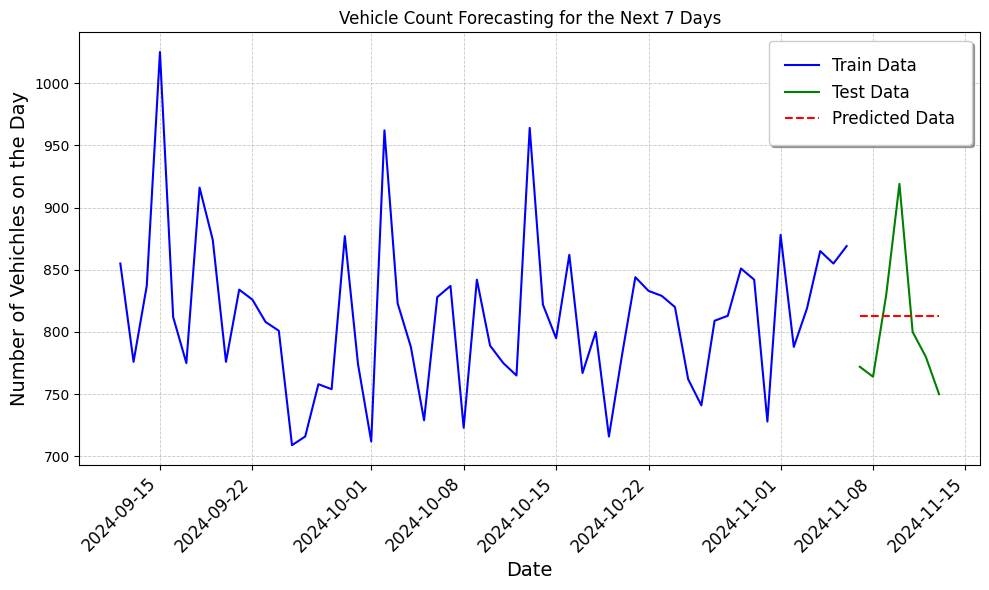

In [242]:
plt.figure(figsize=(10, 6))
plt.plot(y_train.index, y_train, label="Train Data", color='blue')
plt.plot(y_test.index, y_test, label="Test Data", color='green')

future_dates = pd.date_range(start=y.index[-8] + pd.Timedelta(days=1), periods=7)
plt.plot(future_dates, y_pred, label="Predicted Data", color='red', linestyle='--')

plt.title('Vehicle Count Forecasting for the Next 7 Days')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Number of Vehichles on the Day', fontsize=14)

plt.xticks(rotation=45, ha='right', fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.6, alpha=0.7)

plt.legend(loc='upper right', fontsize=12, frameon=True, shadow=True, borderpad=1)
plt.tight_layout()
plt.show()


In [243]:
merged_data['time_spent'] = (merged_data['timestamp_exit'] - merged_data['timestamp_entry']).dt.total_seconds() / 3600  # convert to hours


print(merged_data['time_spent'].max())
print(merged_data['time_spent'].min())

avg_time_spent = merged_data.groupby(by=merged_data['timestamp_entry'].dt.date)['time_spent'].mean()


y_time = pd.DataFrame(data=avg_time_spent, index=pd.to_datetime(avg_time_spent.index))

y_train_time, y_test_time = temporal_train_test_split(y_time, test_size=7)

model_time = AutoARIMA(sp=7, suppress_warnings=True, seasonal=True)
model_time.fit(y_train_time)

y_pred_time = model_time.predict(fh=np.arange(1, 8))

mape = MeanAbsolutePercentageError(y_test, y_pred)
mae = MeanAbsoluteError(y_test, y_pred)

print(f"MAPE: {mape}")
print(f"MAE: {mae}")



14.333333333333334
1.0
MAPE: MeanAbsolutePercentageError(multilevel=            vehicle_no
2024-11-07  813.035714
2024-11-08  813.035714
2024-11-09  813.035714
2024-11-10  813.035714
2024-11-11  813.035714
2024-11-12  813.035714
2024-11-13  813.035714,
                            multioutput=                 vehicle_no
timestamp_entry            
2024-11-07              772
2024-11-08              764
2024-11-09              830
2024-11-10              919
2024-11-11              800
2024-11-12              780
2024-11-13              750)
MAE: MeanAbsoluteError(multilevel=            vehicle_no
2024-11-07  813.035714
2024-11-08  813.035714
2024-11-09  813.035714
2024-11-10  813.035714
2024-11-11  813.035714
2024-11-12  813.035714
2024-11-13  813.035714,
                  multioutput=                 vehicle_no
timestamp_entry            
2024-11-07              772
2024-11-08              764
2024-11-09              830
2024-11-10              919
2024-11-11              800
2024-11-1

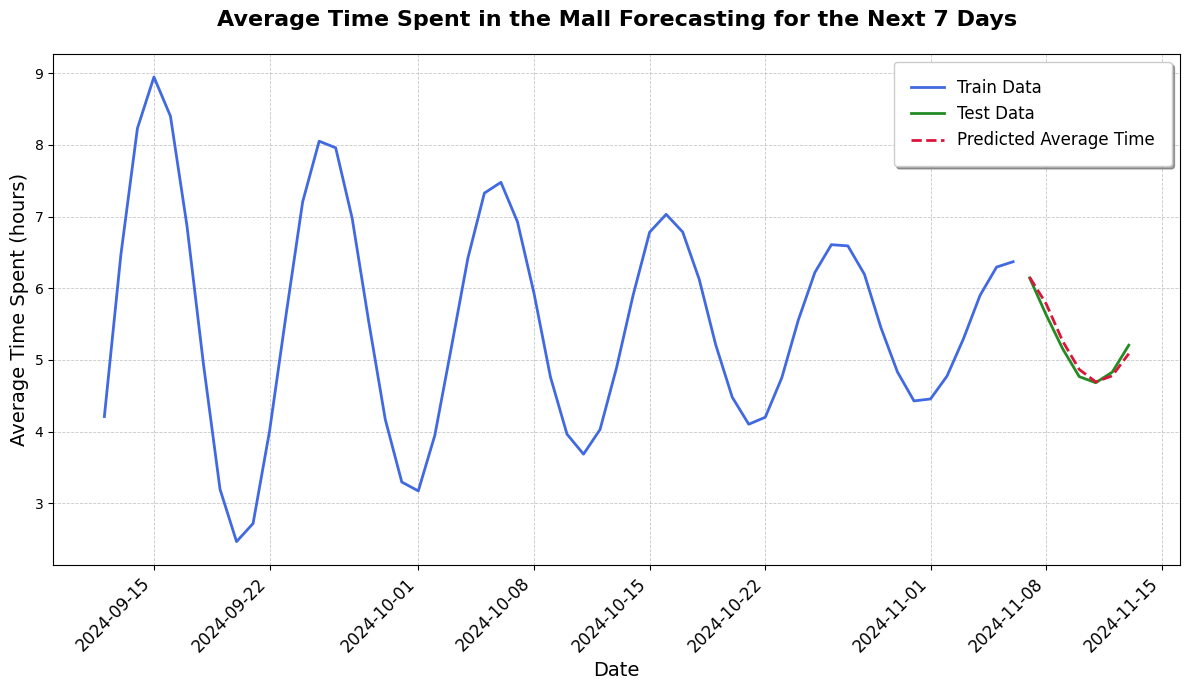

In [244]:
plt.figure(figsize=(12, 7))

plt.plot(y_train_time.index, y_train_time, label="Train Data", color='royalblue', linewidth=2)
plt.plot(y_test_time.index, y_test_time, label="Test Data", color='forestgreen', linewidth=2)

future_dates_time = pd.date_range(start=y_time.index[-8] + pd.Timedelta(days=1), periods=7)
plt.plot(future_dates_time, y_pred_time, label="Predicted Average Time", color='crimson', linestyle='--', linewidth=2)

plt.title('Average Time Spent in the Mall Forecasting for the Next 7 Days', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Average Time Spent (hours)', fontsize=14)

plt.xticks(rotation=45, ha='right', fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.6, alpha=0.7)

plt.legend(loc='upper right', fontsize=12, frameon=True, shadow=True, borderpad=1)
plt.tight_layout()

plt.show()
